In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from dipole import model

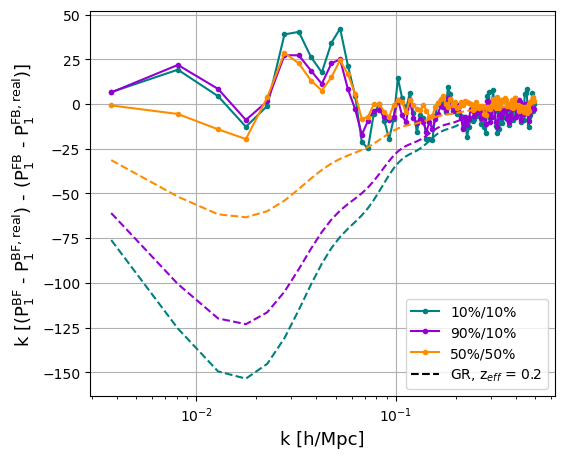

In [14]:
from matplotlib.lines import Line2D

cuts_b = [10,10,50]
cuts_f = [10,90,50]

s_b = [0.98,0.98,0.62]
s_f = [0.3,0.42,0.33]

b_b = [1.3,1.3,1.1]
b_f = [1.05,1.05,1.03]

plt.figure(figsize=(6,5))
colors = ['teal','darkviolet','darkorange']
    
for i, [cut_b, cut_f] in enumerate(zip(cuts_b, cuts_f)):
    
    data_BF = np.loadtxt(f'/global/homes/j/jpiat/data/Pk1_b{cut_b}_f{cut_f}.dat')
    data_FB = np.loadtxt(f'/global/homes/j/jpiat/data/Pk1_f{cut_f}_b{cut_b}.dat')
    data_real_BF = np.loadtxt(f'/global/homes/j/jpiat/data/Pk1_real_b{cut_b}_f{cut_f}.dat')
    data_real_FB = np.loadtxt(f'/global/homes/j/jpiat/data/Pk1_real_f{cut_f}_b{cut_b}.dat')
    
    k = data_BF[:,0]
    pk1_BF = data_BF[:,1]
    pk1_FB = data_FB[:,1]
    pk1_real_BF = data_real_BF[:,1]
    pk1_real_FB = data_real_FB[:,1]
    
    s = [s_b[i], s_f[i]]
    b = [b_b[i], b_f[i]]
    
    pk1_model = model(k,0.2,s,b)
    
    plt.plot(k,k*((pk1_BF-pk1_real_BF)-(pk1_FB-pk1_real_FB)),marker='.',color=colors[i],label=f'{cut_f}%/{cut_b}%')
    plt.plot(k, -2*k*pk1_model, ls = '--', color=colors[i])

line = Line2D([0], [0], label=r'GR, z$_{eff}$ = 0.2', color='k', ls='--')
handles, labels = plt.gca().get_legend_handles_labels()
handles.extend([line])
    
plt.ylabel(r'k [(P$\rm_1^{BF}$ - P$\rm^{BF,real}_1$) - (P$\rm_1^{FB}$ - P$\rm^{FB,real}_1$)]',fontsize=13)
plt.xlabel('k [h/Mpc]', fontsize=13)
plt.xscale('log')
plt.grid()
plt.legend(handles=handles);

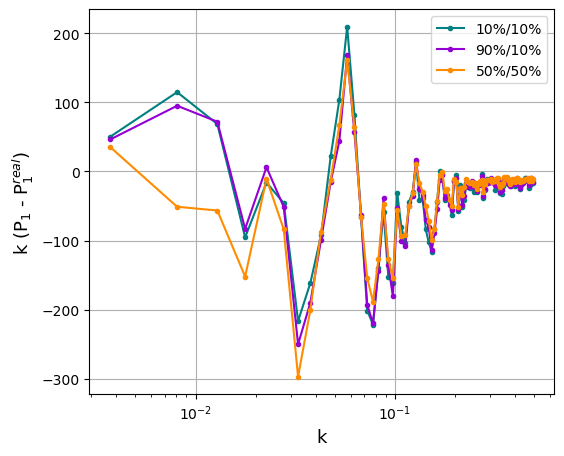

In [4]:
cuts_b = [10,10,50]
cuts_f = [10,90,50]

s_b = [0.98,0.98,0.62]
s_f = [0.3,0.42,0.33]

b_b = [1.3,1.3,1.1]
b_f = [1.05,1.05,1.03]

plt.figure(figsize=(6,5))
colors = ['teal','darkviolet','darkorange']
    
for i, [cut_b, cut_f] in enumerate(zip(cuts_b, cuts_f)):
    
    data = np.loadtxt(f'/global/homes/j/jpiat/data/Pk1_b{cut_b}_f{cut_f}.dat')
    
    k = data[:,0]
    pk1_real = data[:,1]
    
    plt.plot(k,k*pk1_real,marker='.',color=colors[i],label=f'{cut_f}%/{cut_b}%')
    
plt.ylabel(r'k (P$_1$ - P$^{real}_1$)',fontsize=13)
plt.xlabel('k', fontsize=13)
plt.xscale('log')
plt.grid()
plt.legend();

[1.04257534e+01 5.17803804e+02 1.96218491e-04 1.04904175e-05]
[6.57145429e+00 6.21247082e+02 1.37090683e-04 8.58306885e-06]
[6.25938153e+00 1.02098945e+03 1.80006027e-04 9.29832458e-06]


Text(0, 0.5, 'time [min]')

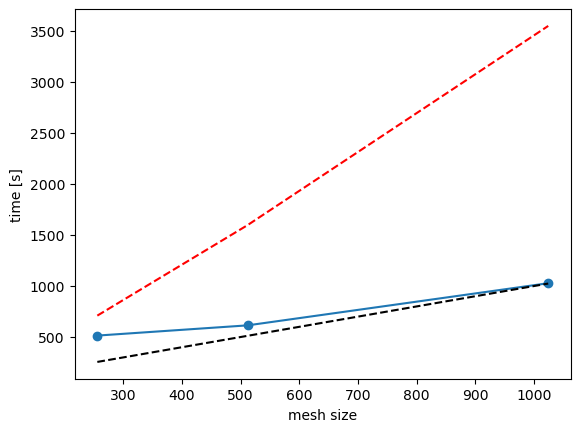

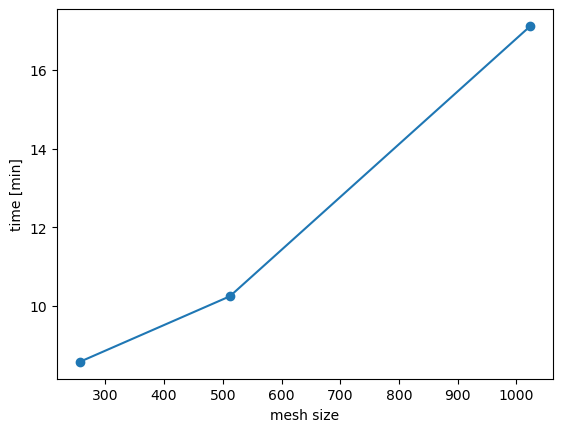

In [33]:
n = np.array([256,512,1024])
time = np.array([514.1038117408752, 614.3950424194336, 1027.4733307361603])

time256 = np.diff([1713914994.4848666, 1713915004.91062, 1713915522.7144237, 1713915522.7146199, 1713915522.7146304])
time512 = np.diff([1713915522.7362378, 1713915529.307692, 1713916150.5547743, 1713916150.5549114, 1713916150.55492])
time51024 = np.diff([1713916150.577391, 1713916156.8367724, 1713917177.826219, 1713917177.826399, 1713917177.8264084])

print(time256)
print(time512)
print(time51024)

plt.figure()
plt.plot(n,time,marker='o')
plt.plot(n,n,'k--')
plt.plot(n,0.5*n*np.log(n),'r--')
plt.xlabel('mesh size')
plt.ylabel('time [s]') 

plt.figure()
plt.plot(n,time/60,marker='o')
plt.xlabel('mesh size')
plt.ylabel('time [min]') 